# **Imports**

In [1]:
# Library Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import mutual_info_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error

from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error
import xgboost as xgb

from tqdm.auto import tqdm
from IPython.display import display


# **DATA file Read and Store in dataframe**

Original data set on kaggle
https://www.kaggle.com/datasets/andrewmvd/autism-screening-on-adults/data

Copy of dataset at below location
https://raw.githubusercontent.com/Arun-Pat/MLZoomCamp_AP/640c35b994c4f2055f637336455781bbed6ba3b8/MidTerm_Project/autism_screening.csv

|Feature |	Description |
|:----------------|:------------------------------------------------|
AX_Score |	Score based on the Autism Spectrum Quotient (AQ) 10 item screening tool AQ-10
age	 | Age in years
gender |	Male or Female
ethnicity |	Ethnicities in text form
jaundice	|Whether or not the participant was born with jaundice?
autism |	Whether or not anyone in tbe immediate family has been diagnosed with autism?
country_of_res |	Countries in text format
used_app_before	| Whether the participant has used a screening app
result |	Score from the AQ-10 screening tool
age_desc |	Age as categorical
relation	 | Relation of person who completed the test
Class/ASD	| Participant classification


In [2]:
url = 'https://raw.githubusercontent.com/Arun-Pat/MLZoomCamp_AP/640c35b994c4f2055f637336455781bbed6ba3b8/MidTerm_Project/autism_screening.csv'

!wget $url
df = pd.read_csv('/content/autism_screening.csv')


--2023-11-02 12:56:47--  https://raw.githubusercontent.com/Arun-Pat/MLZoomCamp_AP/640c35b994c4f2055f637336455781bbed6ba3b8/MidTerm_Project/autism_screening.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58253 (57K) [text/plain]
Saving to: ‘autism_screening.csv’

autism_screening.cs 100%[===================>]  56.89K  --.-KB/s    in 0.002s  

2023-11-02 12:56:48 (29.7 MB/s) - ‘autism_screening.csv’ saved [58253/58253]



In [3]:
df.head(2)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,United States,no,6.0,18 and more,Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5.0,18 and more,Self,NO


# EDA - **Data** Initial Prep Analysis

First make data consitent with making all lowercase and replacing spaces with underscores for text data


1. How big is data?How many and what type of columns
2. What is general stats info about numerical columns
2. Any columns having null? - Age column has 2 nulls
2. Any columns having missing values?
3. What are unique values in each columns
3. Any columns needs data correction?

In [4]:
# Make column names lowercase and replace spaces with underscore in name
# Also correct  some misspellings of column names

df.columns=df.columns.str.strip().str.lower().str.replace(' ','_').str.replace('/','_')
df = df.rename(columns={'austim' : 'autism', 'jundice': 'jaundice', 'contry_of_res' : 'country_of_res'})

# Change all categorical data to small case with space replaced by underscore
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.strip().str.replace(' ', '_')


In [5]:
display(df.shape)
pd.DataFrame([df.dtypes, df.nunique()]).T  # Data Types and unique values


(704, 21)

,0,1
a1_score,int64,2
a2_score,int64,2
a3_score,int64,2
a4_score,int64,2
a5_score,int64,2
a6_score,int64,2
a7_score,int64,2
a8_score,int64,2
a9_score,int64,2
a10_score,int64,2


In [6]:
df.describe()
# observations
# Max age - Record with 383 age seems to be incorrect

,a1_score,a2_score,a3_score,a4_score,a5_score,a6_score,a7_score,a8_score,a9_score,a10_score,age,result
count,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,702.000000,704.000000
mean,0.721591,0.453125,0.457386,0.495739,0.498580,0.284091,0.417614,0.649148,0.323864,0.573864,29.698006,4.875000
std,0.448535,0.498152,0.498535,0.500337,0.500353,0.451301,0.493516,0.477576,0.468281,0.494866,16.507465,2.501493
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,3.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,27.000000,4.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,7.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,383.000000,10.000000


In [7]:
# Find columns with null values
col_with_null = df.columns[df.isna().any()]
df[col_with_null].isnull().sum()


age    2
dtype: int64

In [8]:
# Find unique values in each column to check any off values
text_columns = df.select_dtypes(include='object').columns
for column in text_columns:
    print(f'{column} :  {df[column].unique()}\n')

gender :  ['f' 'm']

ethnicity :  ['white-european' 'latino' '?' 'others' 'black' 'asian' 'middle_eastern'
 'pasifika' 'south_asian' 'hispanic' 'turkish']

jaundice :  ['no' 'yes']

autism :  ['no' 'yes']

country_of_res :  ['united_states' 'brazil' 'spain' 'egypt' 'new_zealand' 'bahamas'
 'burundi' 'austria' 'argentina' 'jordan' 'ireland' 'united_arab_emirates'
 'afghanistan' 'lebanon' 'united_kingdom' 'south_africa' 'italy'
 'pakistan' 'bangladesh' 'chile' 'france' 'china' 'australia' 'canada'
 'saudi_arabia' 'netherlands' 'romania' 'sweden' 'tonga' 'oman' 'india'
 'philippines' 'sri_lanka' 'sierra_leone' 'ethiopia' 'viet_nam' 'iran'
 'costa_rica' 'germany' 'mexico' 'russia' 'armenia' 'iceland' 'nicaragua'
 'hong_kong' 'japan' 'ukraine' 'kazakhstan' 'americansamoa' 'uruguay'
 'serbia' 'portugal' 'malaysia' 'ecuador' 'niger' 'belgium' 'bolivia'
 'aruba' 'finland' 'turkey' 'nepal' 'indonesia' 'angola' 'azerbaijan'
 'iraq' 'czech_republic' 'cyprus']

used_app_before :  ['no' 'yes']

age

In [9]:
# Iterate through the columns and find unique values and counts
unique_value_counts = {}

for column in text_columns:
    value_counts = df[column].value_counts()
    unique_value_counts[column] = value_counts

display(unique_value_counts)

{'gender': m    367
 f    337
 Name: gender, dtype: int64,
 'ethnicity': white-european    233
 asian             123
 ?                  95
 middle_eastern     92
 black              43
 south_asian        36
 others             31
 latino             20
 hispanic           13
 pasifika           12
 turkish             6
 Name: ethnicity, dtype: int64,
 'jaundice': no     635
 yes     69
 Name: jaundice, dtype: int64,
 'autism': no     613
 yes     91
 Name: autism, dtype: int64,
 'country_of_res': united_states           113
 united_arab_emirates     82
 new_zealand              81
 india                    81
 united_kingdom           77
                        ... 
 china                     1
 chile                     1
 lebanon                   1
 burundi                   1
 cyprus                    1
 Name: country_of_res, Length: 67, dtype: int64,
 'used_app_before': no     692
 yes     12
 Name: used_app_before, dtype: int64,
 'age_desc': 18_and_more    704
 Name: age_des

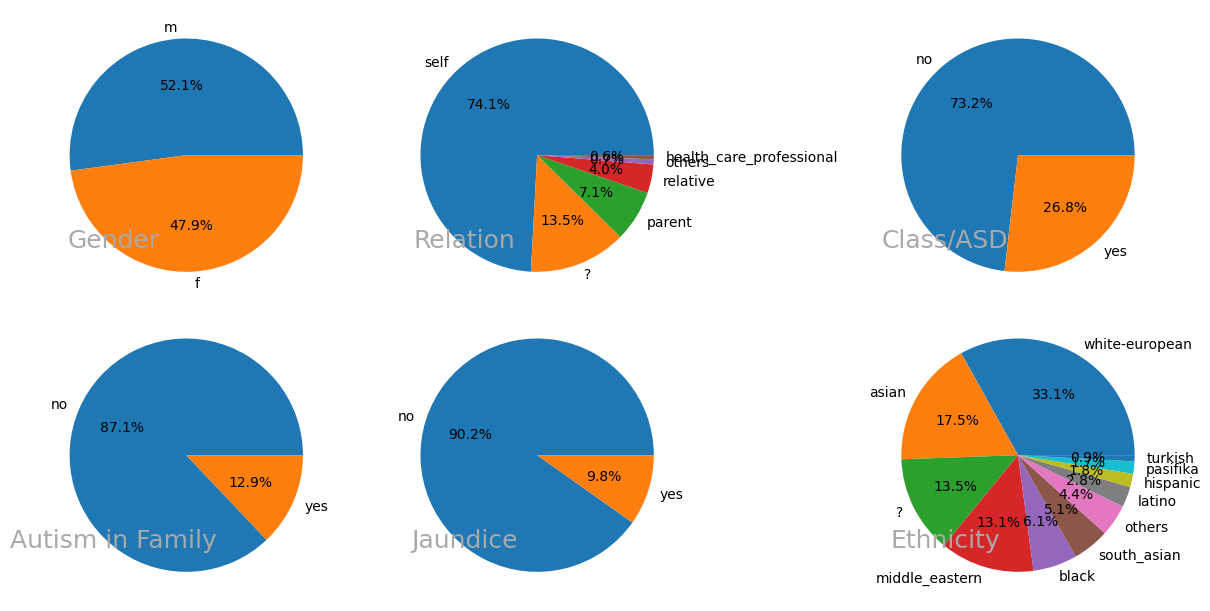

In [10]:
# Helper function used for visualization
def identify_axes(ax_dict, fontsize=18):
    """
    Helper to identify the Axes in the examples below.
    ----------
    ax_dict : dict[str, Axes] :  Mapping between the title / label and the Axes.
    fontsize : int, optional  :  How big the label should be.
    """
    # kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    kw = dict(ha="center", va="top", fontsize=fontsize, color="darkgrey")

    for k, ax in ax_dict.items():
        ax.text(0.25, 0.25, k, transform=ax.transAxes, **kw)


# Plot multiple Pie Charts
fig = plt.figure(figsize=[12, 6],layout="constrained")
ax_dict = fig.subplot_mosaic(
    [
        ["Gender", "Relation","Class/ASD"],
        ["Autism in Family","Jaundice","Ethnicity"],
        # ["Autism in Family","Jaundice","App Used Before"],
    ],
)
ax_dict["Gender"].pie(df['gender'].value_counts(), labels=df['gender'].value_counts().index, autopct='%1.1f%%')
ax_dict["Relation"].pie(df['relation'].value_counts(), labels=df['relation'].value_counts().index, autopct='%1.1f%%')
ax_dict["Class/ASD"].pie(df['class_asd'].value_counts(), labels=df['class_asd'].value_counts().index, autopct='%1.1f%%')
ax_dict["Autism in Family"].pie(df['autism'].value_counts(), labels=df['autism'].value_counts().index, autopct='%1.1f%%')
ax_dict["Jaundice"].pie(df['jaundice'].value_counts(), labels=df['jaundice'].value_counts().index, autopct='%1.1f%%')
# ax_dict["App Used Before"].pie(df['used_app_before'].value_counts(), labels=df['used_app_before'].value_counts().index, autopct='%1.1f%%')
ax_dict["Ethnicity"].pie(df['ethnicity'].value_counts(), labels=df['ethnicity'].value_counts().index, autopct='%1.1f%%')

# ax_dict["Country"].bar(df['contry_of_res'].value_counts().index,df['contry_of_res'].value_counts())


identify_axes(ax_dict)


united_states           113
united_arab_emirates     82
new_zealand              81
india                    81
united_kingdom           77
                       ... 
china                     1
chile                     1
lebanon                   1
burundi                   1
cyprus                    1
Name: country_of_res, Length: 67, dtype: int64

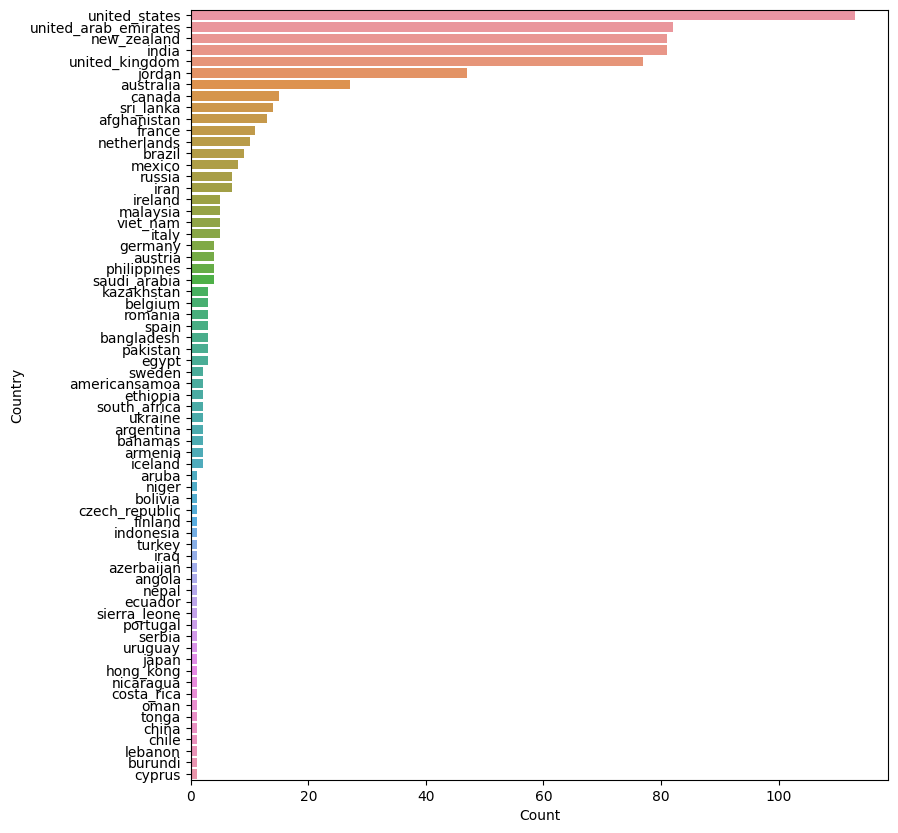

In [11]:
# # Observe countrywise ASD count in data
display(df['country_of_res'].value_counts())
fig, ax = plt.subplots(figsize=(9,10))
fig = sns.barplot(y=df['country_of_res'].value_counts().index[::], x=df['country_of_res'].value_counts().values[::], data=df)
fig.set(xlabel='Count', ylabel='Country')
plt.show()

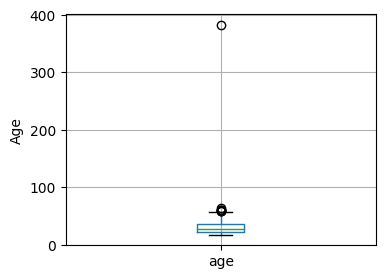

In [12]:
# Find if any eroronous values in Age column
plt.figure(figsize=(4, 3))
# plt.boxplot(df.age)
df.boxplot(column='age')
plt.ylabel("Age")
plt.show()



<Axes: xlabel='class_asd', ylabel='result'>

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 65.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


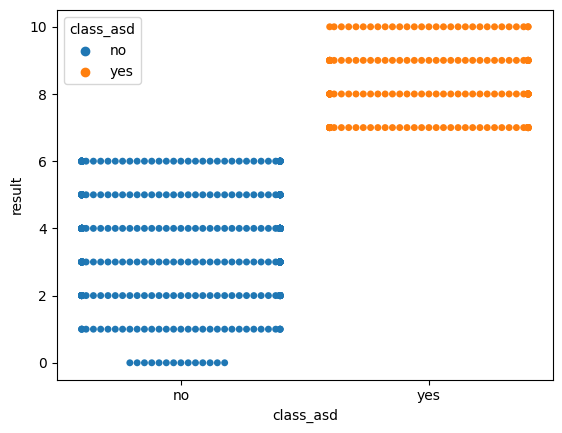

In [13]:
# Association between 'result' and 'Class/ASD'. As ASD is devided based on this score
sns.swarmplot(x='class_asd', y='result', data=df, hue = "class_asd",warn_thresh=0.5)

### Data preprocessing
1. In all categorical columns Change any values to lowercase and replace _ for space
2. Modify null values to avg in  "age" columns. Also change one outlier having 383 age also to average value
3. Replace value ? in columns ethinicity to "Unknown" and Relation to "Other"
4. Since column 'age_desc' has just one value throughout the data, we can drop
 it.
5. Change target class Class/ASD labels YES and NO with 1 and 0 respectively.
6.

In [14]:
# Replace null and sole outlier with mean value
mean_age = int(df['age'].mean())
df.age = df.age.fillna(mean_age)
df.loc[df.age == df.age.max(), 'age'] = mean_age

# It makes sense to replace ? in relation with mode as the 74% is dominated as self category.
# However for ethniciy as ? category is significant (13.5%) Clubbing it with Others will make others as significant category
# So replacing it with "unknown"
mode_relation = df['relation'].mode().iloc[0]
df['relation'].replace('?', mode_relation, inplace=True)
# df['relation'].value_counts()

df['ethnicity'].replace('?', 'unknown', inplace=True)
# df['ethnicity'].value_counts()


df.class_asd = (df.class_asd == 'yes').astype(int)
# df.class_asd.value_counts()

# **SPLIT the DATA in Train, val and Test**

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [16]:
len(df),len(df_full_train),len(df_train), len(df_val), len(df_test)

(704, 563, 422, 141, 141)

In [17]:
df_train.shape

(422, 21)

In [18]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [19]:
y_train = df_train.class_asd.values
y_val = df_val.class_asd.values
y_test = df_test.class_asd.values

In [20]:
del df_train['class_asd']
del df_val['class_asd']
del df_test['class_asd']

# **Feature Importance: Check Corelation and Mutual Info Matrix**

In [23]:
all_categorical = list (df_train.dtypes[df_train.dtypes == object].index)
all_numerical = list (df_train.dtypes[(df_train.dtypes != object) ].index)
display(all_categorical,all_numerical)

['gender',
 'ethnicity',
 'jaundice',
 'autism',
 'country_of_res',
 'used_app_before',
 'age_desc',
 'relation']

['a1_score',
 'a2_score',
 'a3_score',
 'a4_score',
 'a5_score',
 'a6_score',
 'a7_score',
 'a8_score',
 'a9_score',
 'a10_score',
 'age',
 'result']

**Corelation**

<ipython-input-24-8c45d4d7b13c>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(df_full_train.corr(), annot=True, cmap="seismic", annot_kws={"fontsize":6})


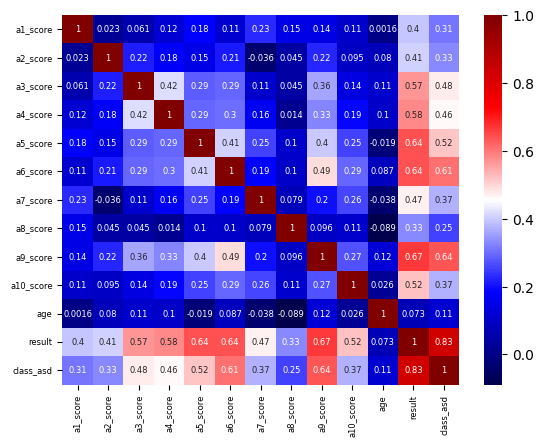

In [24]:
# For Numerical Valriable, check the corelation Matrix with heatmp for full training dataset
fig, ax = plt.subplots()
# plt.figure(figsize=(35,30))
ax = sns.heatmap(df_full_train.corr(), annot=True, cmap="seismic", annot_kws={"fontsize":6})
ax.tick_params(axis='both', which='major', labelsize=6)
plt.show()

#  Appears that Scores AQ Scores 5,6,9 and result looks to be corelated with class_asd in deciding ASD diagnostic assessment.

Mutual Information

In [25]:
def mutual_info_asd_score(series):
    return mutual_info_score(series, df_full_train.class_asd)

mi = df_full_train[all_categorical].apply(mutual_info_asd_score)
mi.sort_values(ascending=False)

# Only few catergorical features seems to have okay score. Seems numerical features carry more significance
# age_description with only one value does not have any significance

country_of_res     0.159776
ethnicity          0.083082
autism             0.013423
jaundice           0.004223
relation           0.001850
gender             0.001561
used_app_before    0.001062
age_desc           0.000000
dtype: float64

# **Select Features for training**

In [26]:
# categorical = ['gender', 'ethnicity', 'jaundice', 'autism',  'country_of_res', 'used_app_before', 'age_desc', 'relation']
# numerical =['a1_score', 'a2_score', 'a3_score', 'a4_score', 'a5_score', 'a6_score', 'a7_score', 'a8_score', 'a9_score', 'a10_score', 'age', 'result']

categorical = ['gender', 'ethnicity', 'jaundice', 'autism',  'country_of_res', 'relation']
numerical =['a1_score', 'a2_score', 'a3_score', 'a4_score', 'a5_score', 'a6_score', 'a7_score', 'a8_score', 'a9_score', 'a10_score', 'age' ]

# **One Hot Encoding**

In [27]:
# one-hot coding
dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dict)


# **Trying Various algorithms to train and See result**

# Training logistic regression with Scikit-Learn

In [28]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [29]:
y_pred = model.predict_proba(X_val)[:, 1]

In [30]:
asd_decision = (y_pred >= 0.5)
(y_val == asd_decision).mean()


0.9645390070921985

In [31]:
accuracy = accuracy_score(y_val, y_pred >= 0.5)

In [32]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

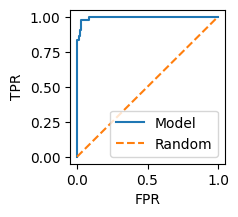

In [33]:
plt.figure(figsize=(2, 2))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [34]:
auc(fpr, tpr)

0.994779307071666

**Which Features removal makes impact?**

In [35]:
def remove_element_from_list(input_list, element_to_remove):
    my_list = input_list.copy()
    try:
        my_list.remove(element_to_remove)
    except ValueError:
        # Handle the case where the element is not in the list
        pass
    return my_list

In [36]:
all_features = categorical + numerical

for i in all_features:

    applied_features= remove_element_from_list(all_features,i)
    # print(f'Removed <<{i}>> Applied Features: {applied_features}')

    dv = DictVectorizer(sparse=False)
    train_dict = df_train[applied_features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val[applied_features].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    model.intercept_[0]  # this is w0
    model.coef_[0].round(3) # This Wi
    y_pred = model.predict_proba(X_val)[:, 1]

    price_decision = (y_pred >= 0.5)
    changed_accuracy = (y_val == price_decision).mean()
    # changed_accuracy = round((above_average_val == price_decision).mean(),2)

    # print(f'Accuracy after removing feature <<{i}>> is {changed_accuracy} with deviation from all feature accuracy: {accuracy - changed_accuracy}')
    print(f'Impact of removing feature <<{i}>> is {accuracy - changed_accuracy}')

Impact of removing feature <<gender>> is -0.007092198581560294
Impact of removing feature <<ethnicity>> is -0.014184397163120588
Impact of removing feature <<jaundice>> is 0.007092198581560183
Impact of removing feature <<autism>> is -0.007092198581560294
Impact of removing feature <<country_of_res>> is -0.007092198581560294
Impact of removing feature <<relation>> is -0.007092198581560294
Impact of removing feature <<a1_score>> is 0.05673758865248224
Impact of removing feature <<a2_score>> is 0.049645390070921946
Impact of removing feature <<a3_score>> is 0.028368794326241065
Impact of removing feature <<a4_score>> is 0.028368794326241065
Impact of removing feature <<a5_score>> is 0.014184397163120477
Impact of removing feature <<a6_score>> is 0.028368794326241065
Impact of removing feature <<a7_score>> is 0.049645390070921946
Impact of removing feature <<a8_score>> is 0.04255319148936165
Impact of removing feature <<a9_score>> is 0.05673758865248224
Impact of removing feature <<a10_sc

In [37]:
#@ CALCULATING ROC AUC SCORE:
for feat in numerical:
    auc_score = roc_auc_score(y_train, df_train[feat])
    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -df_train[feat])
    print(f'{feat} - auc: {round(auc_score,3)}')

a1_score - auc: 0.659
a2_score - auc: 0.692
a3_score - auc: 0.803
a4_score - auc: 0.773
a5_score - auc: 0.792
a6_score - auc: 0.825
a7_score - auc: 0.701
a8_score - auc: 0.63
a9_score - auc: 0.84
a10_score - auc: 0.706
age - auc: 0.554


# **Decision tree Classifier**

In [38]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20,25,30,60,90,100, None]
min_samples = [1, 5, 10, 15, 20, 500, 100, 200]
scores = []

for depth in depths:
    for s in min_samples:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((depth, s, auc))

In [39]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc                                                   \
max_depth           NaN  1.0    2.0    3.0    4.0    5.0    6.0    10.0    
min_samples_leaf                                                           
1                 0.815  0.743  0.857  0.841  0.874  0.882  0.823  0.820   
5                 0.889  0.743  0.857  0.873  0.880  0.882  0.888  0.889   
10                0.895  0.743  0.857  0.873  0.888  0.893  0.895  0.895   
15                0.890  0.743  0.857  0.890  0.895  0.890  0.890  0.890   
20                0.894  0.743  0.857  0.890  0.894  0.894  0.894  0.894   
100               0.825  0.743  0.825  0.825  0.825  0.825  0.825  0.825   
200               0.783  0.783  0.783  0.783  0.783  0.783  0.783  0.783   
500               0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500   

                                                                   
max_depth         15.0   20.0   25.0   30.0   60.0   90.0   100.0  
min_samples_leaf                                                   
1                 0.815  0.815  0.820  0.809  0.815  0.815  0.815  
5                 0.889  0.889  0.889  0.889  0.890  0.889  0.890  
10                0.895  0.895  0.895  0.895  0.895  0.895  0.895  
15                0.890  0.890  0.890  0.890  0.890  0.890  0.890  
20                0.894  0.894  0.894  0.894  0.894  0.894  0.894  
100               0.825  0.825  0.825  0.825  0.825  0.825  0.825  
200               0.783  0.783  0.783  0.783  0.783  0.783  0.783  
500               0.500  0.500  0.500  0.500  0.500  0.500  0.500

# **Random Forest**

In [40]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [41]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

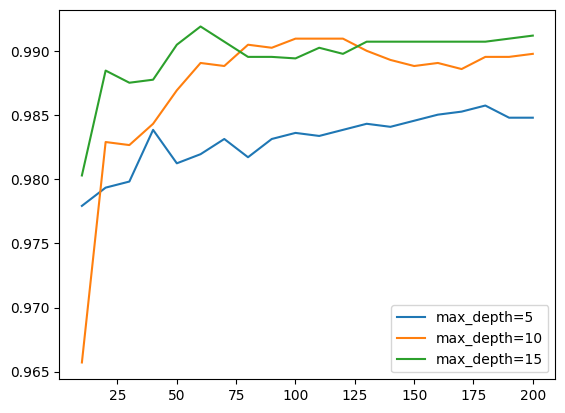

In [42]:

for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]

    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)
plt.legend()


In [45]:
max_depth = 15


In [46]:
scores = []

for s in [1,2, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [47]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

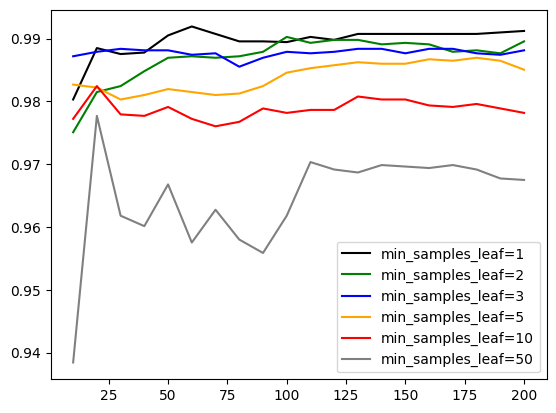

In [48]:
colors = ['black', 'green','blue', 'orange', 'red', 'grey']
values = [1, 2, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]

    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

# **Feature Importance from Tree based Models**

In [49]:
rf = RandomForestClassifier(n_estimators=200,
                                    max_depth=15,
                                    min_samples_leaf=2,
                                    random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=2, n_estimators=200,
                       random_state=1)

In [50]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False)

,feature,importance
6,a6_score,0.179446
9,a9_score,0.172252
3,a3_score,0.126233
5,a5_score,0.094901
4,a4_score,0.069625
...,...,...
57,country_of_res=sierra_leone,0.000000
29,country_of_res=egypt,0.000000
61,country_of_res=sweden,0.000000
62,country_of_res=tonga,0.000000


# **XGBoost**

In [51]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [55]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [56]:
y_pred = model.predict(dval)

In [57]:
roc_auc_score(y_val, y_pred)

0.9630991931656384

In [65]:
xgb_params = {
    'eta': 0.6,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [66]:
y_pred = model.predict(dval)

In [67]:
roc_auc_score(y_val, y_pred)

0.9907451352634078